## Vineyard and Fermentation phyllosphere microbiome ITS gene analysis
## QIIME2 Code

#### Brady L. Welsh, May 2023
  

### First, load and import data into QIIME2.

In [ ]:
conda activate qiime2-2021.8

In [ ]:
cd Reads

Make manifest file:

In [ ]:
#Create manifest file for QIIME2 import using BASH commands:
echo "sample-id" > sample-id.txt && \
echo "forward-absolute-filepath" > r1.txt \
&& echo "reverse-absolute-filepath" > r2.txt

for i in ./*_R1_001.fastq.gz; do echo $(basename ${i/_S*/}) >> sample-id.txt; done
sed -i'' 's/_/-/g' sample-id.txt
for i in ./*_R1_001.fastq.gz; do echo "$PWD"/$i >> r1.txt; done
for i in ./*_R2_001.fastq.gz; do echo "$PWD"/$i >> r2.txt; done

paste sample-id.txt r1.txt r2.txt > ./ITS-manifest.tsv && rm *.txt

and import:

In [ ]:
qiime tools import \
	--type 'SampleData[PairedEndSequencesWithQuality]' \
	--input-path manifest.tsv \
	--input-format PairedEndFastqManifestPhred33V2 \
	--output-path ITS-demux.qza

### Note, you'll need to adjust the absolute filepaths in the 'manifest.txt' file to match your system.

In [ ]:
qiime demux summarize \
    --i-data ITS-demux.qza \
    --o-visualization ITS-demux.qzv

Quality plots:

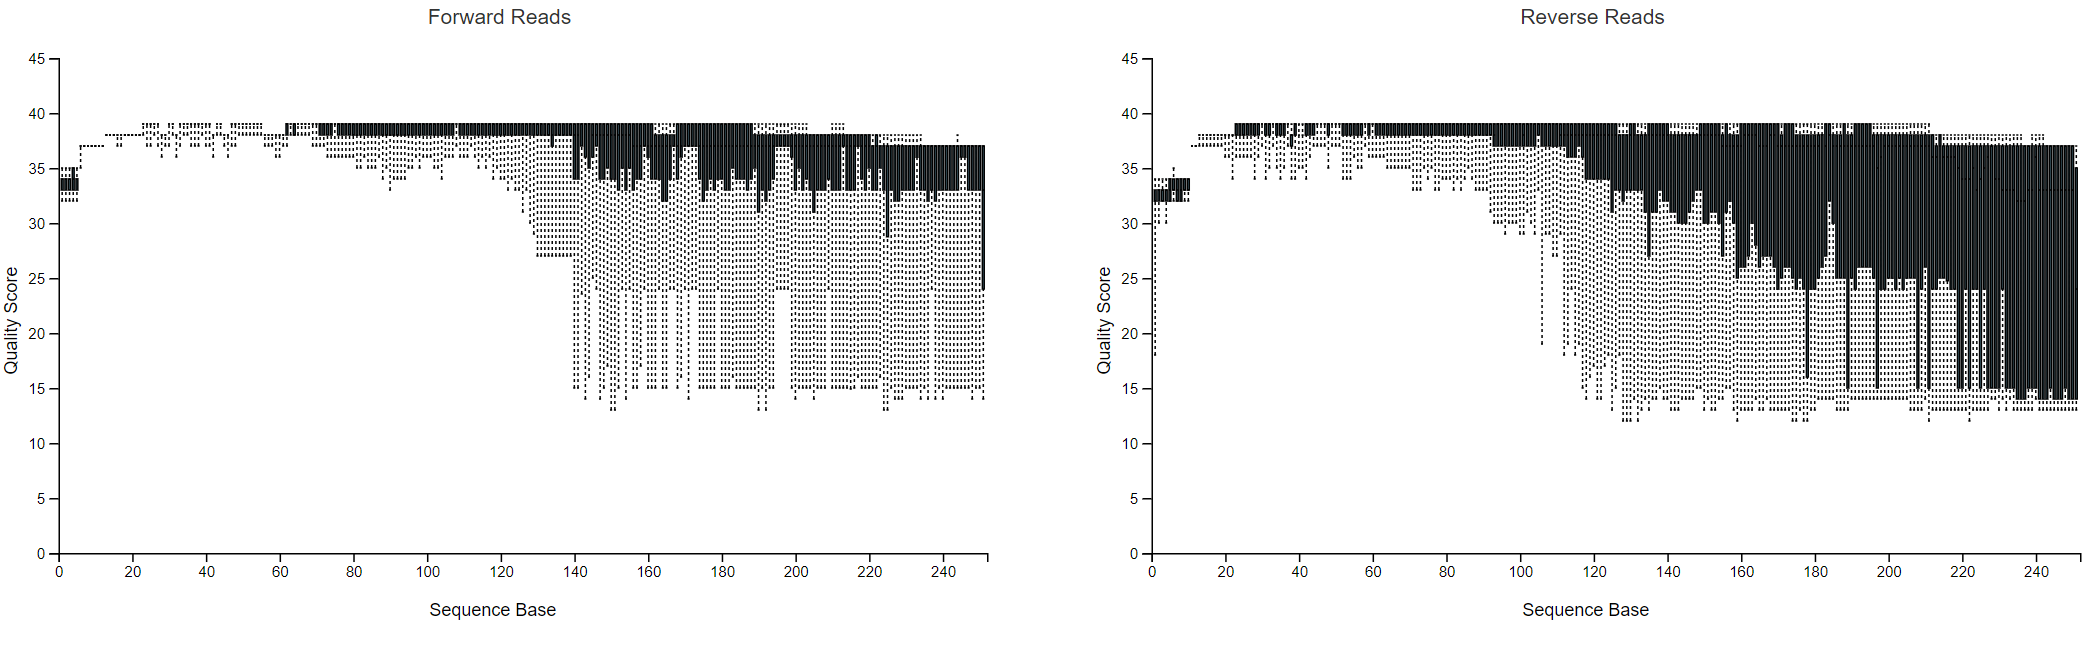

Qualities fairly high throughout with some reduction in read quality by the end of the read.

In [ ]:
cd ITS_Fungi_ITS1-ITS2R

In [ ]:
qiime dada2 denoise-paired \
	--i-demultiplexed-seqs reads/ITS-demux.qza \
 	--p-trim-left-f 0 \
 	--p-trim-left-r 0 \
 	--p-trunc-len-f 0 \
 	--p-trunc-len-r 0 \
	--p-n-threads 4 \
	--verbose \
 	--o-table data/QIIME2_output/Vineyard-ITS-table.qza \
 	--o-representative-sequences data/QIIME2_output/Vineyard-ITS-rep-seq.qza \
 	--o-denoising-stats data/QIIME2_output/Vineyard-ITS-DADA2-stats.qza

In [ ]:
cd data/QIIME2_output

In [ ]:
qiime metadata tabulate \
    --m-input-file Vineyard-ITS-rep-seq.qza \
    --o-visualization Vineyard-ITS-rep-seq.qzv

In [ ]:
qiime feature-table summarize \
    --i-table Vineyard-ITS-table.qza \
    --o-visualization Vineyard-ITS-table.qzv

### Assign taxonomy using a naive bayesian classifier against the UNITE ITS database:

In [ ]:
qiime feature-classifier classify-sklearn \
	--i-classifier unite-ver9-99-classifier-27.10.2022.qza \
	--i-reads Vineyard-ITS-rep-seq.qza \
	--o-classification Vineyard-ITS-UNITE.qza \
    --p-n-jobs 24

In [ ]:
qiime metadata tabulate \
    --m-input-file Vineyard-ITS-UNITE.qza \
    --o-visualization Vineyard-ITS-UNITE.qzv

### Tidy Table and Filtering

In [ ]:
qiime feature-table filter-samples \
  	--i-table Vineyard-ITS-table.qza \
  	--m-metadata-file metadata/Vineyard-ITS-metadata_tidy.tsv \
  	--o-filtered-table Vineyard-ITS-table_tidy.qza

Ran decontam but found no contaminating features.

In [ ]:
# Remove Control Samples

qiime feature-table filter-samples \
  	--i-table Vineyard-ITS-table_tidy.qza \
  	--m-metadata-file metadata/Vineyard-ITS-metadata_nocontrols.tsv \
  	--o-filtered-table table1.qza && \

echo 'Done Table 1' && \
# Remove ASVs With <10 Seqs

qiime feature-table filter-features \
  	--i-table table1.qza \
  	--p-min-frequency 10 \
  	--o-filtered-table Vineyard-ITS-table_filtered.qza && \

echo 'Done Filtering' && \

rm Vineyard-ITS-table_tidy.qza && rm table1.qza && \

echo 'Directory Cleaned'

### Run alpha-rarefaction analysis to see what a good sampling depth will be:

In [ ]:
qiime diversity alpha-rarefaction \
--i-table Vineyard-ITS-table_filtered.qza \
--m-metadata-file metadata/Vineyard-ITS-metadata_nocontrols.tsv \
--o-visualization table-rarefaction.qzv \
--p-min-depth 350 \
--p-max-depth 5000

Rarefaction Plot:

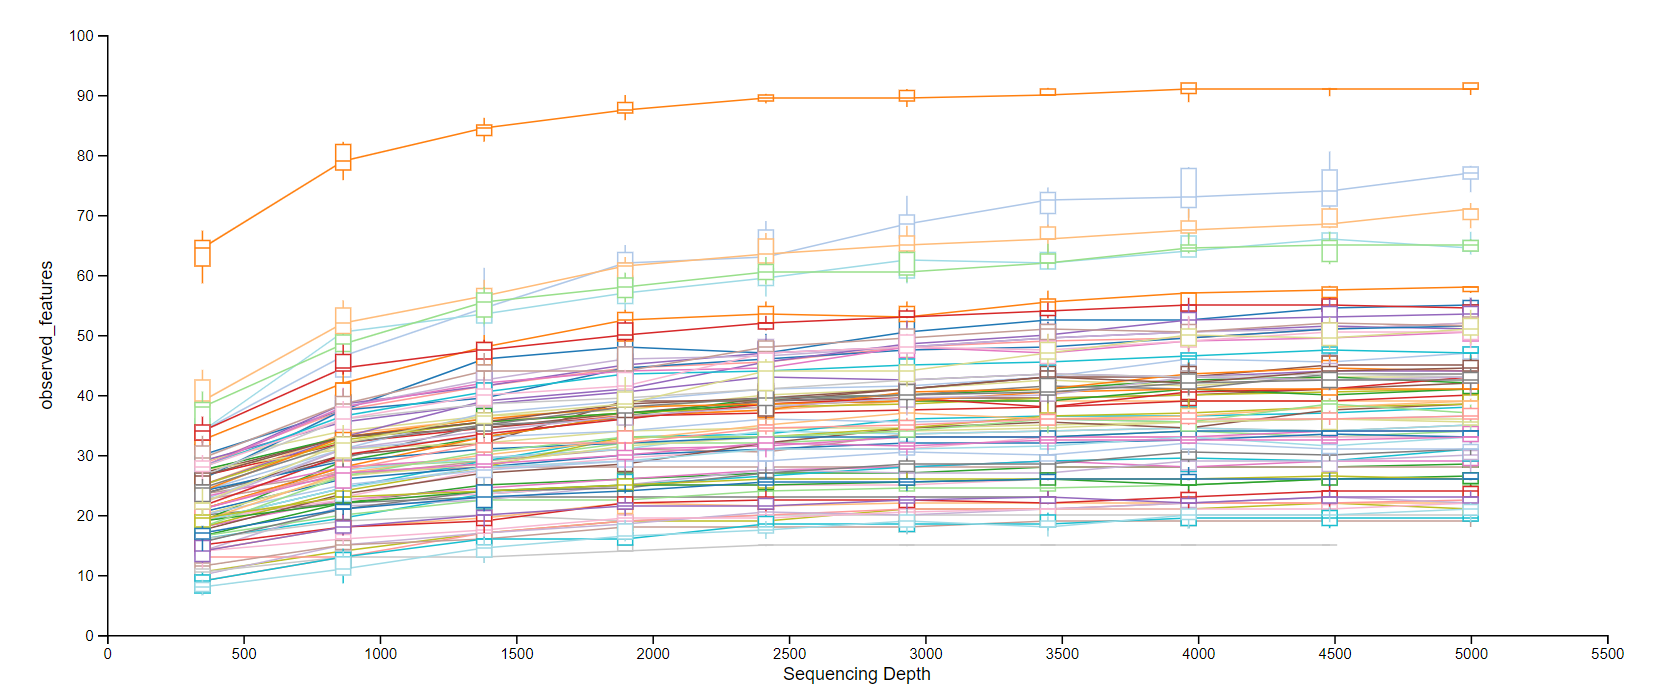

Feature number seems to plateau quickly, around 1500, likely due to low number of features. 